# Preâmbulo

In [ ]:
!wget https://www.dropbox.com/s/f8k3xoywff0h3br/questions-words.csv

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import string

import torch
from torch import nn
### LIB DE TEXTO DO PYTORCH
import torchtext
from torchtext import data

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Analogias

Uma forma intrínseca de avaliar a qualidade de um modelo de linguagem é realizar as chamadas analogias a partir das **representações distribuídas** gerada pelo modelo.

Analogias são associações de mesma natureza entre palavras (como flexões de gênero ou número). A geometria dessas associações pode ser visualizada no espaço vetorial onde as palavras são projetadas e, em modelos bem treinados, deve ser possível encontrar semelhanças entre associações de mesma natureza.
<img width=600 src="https://vecto.space/assets/img/queen.png">

Vamos trabalhar com um popular conjunto de validação através do método de analogias. Ele consiste em pares de associações, onde o primeiro par deve ser usado como referência para completar o segundo par. No exemplo a seguir, Brasil é a palavra que deve ser inferida a partir das três palavras marcadas em negrito. 
> **Buenos Aires** está para **Argentina** assim como **Brasília** está para <span style="color:red"><u>**Brasil**<u></span>
    
Na prática, essa é a composição do conjunto `questions-words` para validação de modelos de linguagem.

In [ ]:
df = pd.read_csv('questions-words.csv')
display(df.head(10))
display(df.tail(10))

,input,analogy
0,Athens Greece Baghdad,Iraq
1,Athens Greece Bangkok,Thailand
2,Athens Greece Beijing,China
3,Athens Greece Berlin,Germany
4,Athens Greece Bern,Switzerland
5,Athens Greece Cairo,Egypt
6,Athens Greece Canberra,Australia
7,Athens Greece Hanoi,Vietnam
8,Athens Greece Havana,Cuba
9,Athens Greece Helsinki,Finland


,input,analogy
19534,write writes sing,sings
19535,write writes sit,sits
19536,write writes slow,slows
19537,write writes speak,speaks
19538,write writes swim,swims
19539,write writes talk,talks
19540,write writes think,thinks
19541,write writes vanish,vanishes
19542,write writes walk,walks
19543,write writes work,works


## Torchtext
Documentação: https://pytorch.org/text/stable/index.html

Similar ao `torchvision` para imagens, o pacote torchtext facilita o trabalho com dados textuais. Em sua documentação é possível explorar toda a sua gama de possibilidades, entre modelos pré-treinados, métricas, ferramentas, datasets, etc.

Aqui vamos conhecer dois elementos importantes para o carregamento de dados.


### Field

Objeto que carrega informações de como os dados devem ser processados. A seguir temos a assinatura da sua classe com alguns exemplos de parâmetros que podemos controlar. 

```python
torchtext.data.Field(dtype=torch.int64, preprocessing=None, lower=False, tokenize=None, tokenizer_language='en', include_lengths=False, batch_first=False, stop_words=None, is_target=False)
```

No nosso caso, ambos entrada e saída são sequências de caracteres que passarão pelo mesmo pré-processamento:
* `tokenize`: Separação em **tokens**. Por padrão o Field realiza a tokenização `string.split`
    * Ex: "Bom dia Brasil!" $\rightarrow$ `["Bom", "dia", "Brasil", "!"]` <br><br>
    
* `lower`: Conversão para letras minúsculas, assim evitamos duplicidade de palavras (Atenas $\neq$ atenas).


### TabularDataset

É simples carregar dados tabulares utilizando a classe `TabularDataset`. Basta informar:
* `path`: O caminho do sistema onde o arquivo se encontra <br><br>
* `format`: A formatação do arquivo (csv, tsv, json) <br><br>
* `fields`: Lista de tuplas `(nome, Field)` representando respectivamente o nome associado a cada coluna da sua tabela e o pré-processamento que os dados devem receber. <br><br>
* `skip_header`: Se o seu arquivo possui uma linha de cabeçalho, você pode removê-la definindo esse parâmetro como `True`.

```python
torchtext.data.TabularDataset(path, format, fields, skip_header=False)
```

In [ ]:
INPUT  = data.Field(lower = True)
TARGET = data.Field(lower = True)

dataset = data.TabularDataset('questions-words.csv', format='csv',
                                           fields=[('input', INPUT), ('target',TARGET)],
                                           skip_header=True
                                        )

for k, sample in enumerate(dataset):
    if k % 1000 == 0:
        print(k, vars(sample))

0 {'input': ['athens', 'greece', 'baghdad'], 'target': ['iraq']}
1000 {'input': ['baku', 'azerbaijan', 'dushanbe'], 'target': ['tajikistan']}
2000 {'input': ['dublin', 'ireland', 'kathmandu'], 'target': ['nepal']}
3000 {'input': ['lusaka', 'zambia', 'tehran'], 'target': ['iran']}
4000 {'input': ['rome', 'italy', 'windhoek'], 'target': ['namibia']}
5000 {'input': ['zagreb', 'croatia', 'astana'], 'target': ['kazakhstan']}
6000 {'input': ['philadelphia', 'pennsylvania', 'tampa'], 'target': ['florida']}
7000 {'input': ['wichita', 'kansas', 'shreveport'], 'target': ['louisiana']}
8000 {'input': ['shreveport', 'louisiana', 'oxnard'], 'target': ['california']}
9000 {'input': ['complete', 'completely', 'lucky'], 'target': ['luckily']}
10000 {'input': ['comfortable', 'uncomfortable', 'clear'], 'target': ['unclear']}
11000 {'input': ['good', 'better', 'high'], 'target': ['higher']}
12000 {'input': ['young', 'younger', 'tight'], 'target': ['tighter']}
13000 {'input': ['weak', 'weakest', 'bright']

## Representando os dados como Tensores

Para transformar palavras em dados numéricos, uma solução muito utilizada é mapeá-las em um dicionário contendo o vocabulário completo do conjunto. 

<img src="https://static.packt-cdn.com/products/9781786465825/graphics/B05525_03_01.jpg" width="500">

A depender da quantidade de palavras em seu vocabulário, uma representação *One-Hot* pode ser computacionalmente inviável. Por isso utilizamos as **representações distribuídas**, associando vetores densos a cada palavra de nosso dicionário de modo que esse espaço vetorial aproxime palavras que costumam aparecer no mesmo contexto.

Vamos explorar algumas maneiras de transformar palavras em representações distribuídas. A principal é a partir de **modelos de linguagem pré-treinados**. Através do pacote `torchtext` é possível consultar todos os modelos ali disponíveis.

Algumas nomenclaturas comuns são:

* charngram.**100d**: Indica que a representação desse modelo possui 100 dimensões. <br>
* glove.**6B**.300d: Indica que o modelo foi treinado com 6 Bilhões de tokens.

In [ ]:
torchtext.vocab.pretrained_aliases.keys()

dict_keys(['charngram.100d', 'fasttext.en.300d', 'fasttext.simple.300d', 'glove.42B.300d', 'glove.840B.300d', 'glove.twitter.27B.25d', 'glove.twitter.27B.50d', 'glove.twitter.27B.100d', 'glove.twitter.27B.200d', 'glove.6B.50d', 'glove.6B.100d', 'glove.6B.200d', 'glove.6B.300d'])

Vamos explorar por exemplo o modelo `glove.6B.100d`

In [ ]:
glove = torchtext.vocab.GloVe(name='6B', dim=100)
print("Um total de %d tokens são mapeados por esse modelo."% len(glove.stoi))
print("Os 10 primeiros tokens são", glove.itos[:10])
print("A dimensionalidade da matriz de representação é:", glove.vectors.shape)

Um total de 400000 tokens são mapeados por esse modelo.
Os 10 primeiros tokens são ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]
A dimensionalidade da matriz de representação é: torch.Size([400000, 100])


Usando o objeto do tipo `Field` podemos **construir um vocabulário** contendo somente as palavras (e vetores) relevantes para o nosso problema.

In [ ]:
MAX_VOCAB_SIZE=1000
INPUT.build_vocab(dataset, 
                  max_size=MAX_VOCAB_SIZE,
                  vectors='glove.6B.100d')

print("Um total de %d tokens são mapeados por esse vocabulário."% len(INPUT.vocab.stoi))
print("Os 10 primeiros tokens são", INPUT.vocab.itos[:10])

print('\nÍndice da palavra "fast" no dicionário:', INPUT.vocab.stoi['fast'])
print('Palavra do índice 100 do dicionário:', INPUT.vocab.itos[100])

print('\nDimensionalidade da representação distribuída:', INPUT.vocab.vectors.shape)

Um total de 907 tokens são mapeados por esse vocabulário.
Os 10 primeiros tokens são ['<unk>', '<pad>', 'california', 'texas', 'slow', 'florida', 'arizona', 'quick', 'japan', 'russia']

Índice da palavra "fast" no dicionário: 36
Palavra do índice 100 do dicionário: sing

Dimensionalidade da representação distribuída: torch.Size([907, 100])


## Visualizando o espaço vetorial

Como seria impraticável visualizar um espaço vetorial de centenas de dimensões, um artifício muito utilizado é a abordagem de redução de dimensionalidade intitulada **t-distributed Stochastic Neighbor Embedding (tSNE)**.

O pacote Scikit-Learn nos traz essa funcionalidade de forma simplificada. Caso queira entender melhor o funcionamento desse método, recomendo a leitura [da documentação](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [ ]:
vectors2d = TSNE(n_components=2).fit_transform(INPUT.vocab.vectors)

{'input': ['good', 'better', 'high'], 'target': ['higher']}
{'input': ['hard', 'harder', 'sharp'], 'target': ['sharper']}
{'input': ['hard', 'harder', 'fast'], 'target': ['faster']}


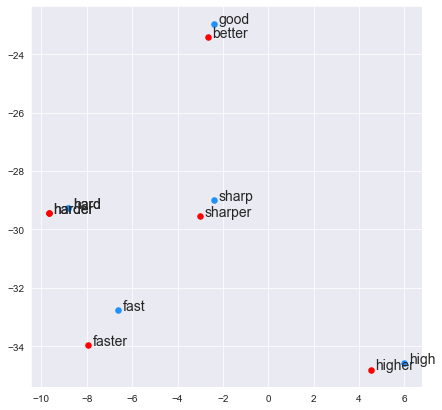

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

examples = [11000,11080, 11102]

for example in examples:
    print(vars(dataset[example]))
    sample = dataset[example]
    entrada = sample.input
    analogia = sample.target[0]

    in_vec  = np.asarray([vectors2d[INPUT.vocab.stoi[e]] for e in entrada])
    out_vec = vectors2d[INPUT.vocab.stoi[analogia]]


    ax.scatter(in_vec[[0,2], 0], in_vec[[0,2], 1], s=30, color='dodgerblue')
    ax.scatter(in_vec[1, 0], in_vec[1, 1], s=30, color='r')
    ax.scatter(out_vec[0], out_vec[1], s=30, color='r')

    for i, word in enumerate(entrada):
        ax.text(in_vec[i,0]+0.2, in_vec[i,1], word, fontsize=14 )
    ax.text(out_vec[0]+0.2, out_vec[1], analogia, fontsize=14 )
        
        
plt.show()        

## Criando analogias

Como dissemos, em um modelo pré-treinado, a geometria do espaço vetorial possui similaridades entre associações de mesma natureza. Podemos explorar essa característica para validar a qualidade de um modelo.

Dado um conjunto de 3 palavras da nossa entrada, exemplo: <br>
`palavras = ['man', 'king', 'woman'`]

Podemos predizer a associaçao entre o primeiro par de palavras: <br>
`associacao = palavra[1] - palavra[0]`

e projetar essa associação na terceira palavra: <br>
`projecao = palavra[2] + associacao`

Essa projeção é um vetor no espaço da representação distribuída que deve estar na vizinhança da analogia que buscamos, nesse caso a palavra `queen`.

<img width=400 src="https://pbs.twimg.com/media/DKWbi9nXoAAd_un.jpg">

In [ ]:
def get_analogy(token_a, token_b, token_c, embed):
    
    vecs = [embed.vectors[embed.stoi[t]] 
                for t in [token_a, token_b, token_c]]
    
    analogy = vecs[1] - vecs[0] + vecs[2]
    
    distances = np.dot(embed.vectors, analogy) / np.linalg.norm(embed.vectors)
    best = np.argsort(distances)
    best = [embed.itos[best[k]] for k in range(-1, -4, -1) if embed.itos[best[k]] not in [token_a, token_b, token_c]]

    return best[0]

In [ ]:
idx = 100
print(vars(dataset[idx]))
words, analogy = dataset[idx].input, dataset[idx].target

prediction = get_analogy(words[0], words[1], words[2], INPUT.vocab)
print(f'\n{words[0].capitalize()} is to {words[1].capitalize()} as {words[2].capitalize()} is to {prediction.capitalize()}')

{'input': ['berlin', 'germany', 'ottawa'], 'target': ['canada']}

Berlin is to Germany as Ottawa is to Canada


## Como aprendemos esses vetores?

Acabamos de ver a representação de palaras como ínidices de um vocabulário fixo. Apesar do índice informar a qual palavra estamos nos referindo, ele não incorpora nenhuma informação semântica sobre a palavra, como por exemplo o contexto no qual ela costuma aparecer. Essa representação semântica pode ser aprendida através de uma **camada de Embedding**.  

![](https://drive.google.com/uc?export=view&id=1pliMSOcjjOZAiR26ycowSeUJsj5cy9W_)

Pense na camada de Embedding como uma tabela $V \times D$, onde $V$ é o número de palavras do seu vocabulário e $D$ é o número de dimensões do espaço vetorial onde você deseja projetar. Colocando a camada de Embedding no início de sua rede neural, o treinamento vai otimizar os parâmetros da sua tabela encontrando o espaço vetorial que mapeia as relações intrínsecas entre as palavras dentro do contexto da otimização. Internamente, essa tabela nada mais é do que uma matriz de pesos a ser otimizada.


No Pytorch, a instância dessa classe recebe como parâmetro ```(vocab_size, embedding_size, padding_idx)```
* ```vocab_size```: Tamanho do vocabulário. Note que **não** se trata da dimensionalidade da entrada.
* ```embedding_size```: Dimensionalidade do espaço latente. Caso haja o aproveitamento de embeddings pré treinadas deve-se definir a dimensionalidade da camada em função dos pesos que serão importados (ex: glove.6b.100d, ```embedding_size=100```).

In [ ]:
class Embed(nn.Module):
  
  def __init__(self,vocab_size, embedding_size, embedding_weights=None):
    super(Embed, self).__init__()
    
    self.embed = nn.Embedding(vocab_size, embedding_size)
    
    if embedding_weights is not None:
        self.embed.weight.data.copy_(embedding_weights)
    
  def forward(self, X):
    return self.embed(X)
    

embedding_size = INPUT.vocab.vectors.shape[1]
vocab_size     = len(INPUT.vocab)

pretrained_embeddings = INPUT.vocab.vectors

net = Embed(vocab_size, embedding_size,
           pretrained_embeddings)

print(net)

Embed(
  (embed): Embedding(907, 100)
)


A seguir vamos refazer todos os passos do carregamento de dados para agregá-los em um só lugar. A única novidade aqui é o uso do `Iterator`, equivalente ao `DataLoader` que já conhecemos, mas com alguns facilitadores para trabalhar com dados textuais.

```python
torchtext.data.Iterator(dataset, batch_size, sort_key=None, device=None, shuffle=None, 
                        sort=None, sort_within_batch=None)
```

In [ ]:
#### Passo 1: Defina os fields e o carregamento do dataset

INPUT  = data.Field(lower = True)
TARGET = data.Field(lower = True)

dataset = data.TabularDataset('questions-words.csv', format='csv',
                                           fields=[('input', INPUT), ('target',TARGET)],
                                           skip_header=True
                                        )

#### Passo 2: Defina o vocabulário **para todos os fields**

MAX_VOCAB_SIZE=1000
INPUT.build_vocab(dataset, 
                  max_size=MAX_VOCAB_SIZE,
                  vectors='glove.6B.100d')

TARGET.build_vocab(dataset, 
                  max_size=MAX_VOCAB_SIZE,
                  vectors='glove.6B.100d')

#### Passo 3: Defina o Iterator (nosso loader de batches)
loader = data.Iterator(dataset, batch_size=10)

for batch in loader:
    
    print(f'Input: {batch.input}\nshape: {batch.input.shape}')
    print(f'\nTarget: {batch.target}\nshape: {batch.target.shape}')
    
    inp = batch.input
    lab = batch.target
    
    embed = net(inp)
    print(f'\nEmbed shape:{embed.shape}')
    
    break

Input: tensor([[140,  54, 161, 103,   4, 220, 253, 205, 374, 215],
        [591, 727, 823, 151, 150, 558, 594, 120,   3, 548],
        [215, 368,  16, 395, 401,  15, 372, 206, 219, 133]])
shape: torch.Size([3, 10])

Target: tensor([[103, 294, 455, 340, 350, 138,   3, 207, 111,  94]])
shape: torch.Size([1, 10])

Embed shape:torch.Size([3, 10, 100])


### Um pequeno exercício

Refaça as analogias (funções copiadas abaixo) adaptando o código para usar a camada de embedding que definimos acima para adquirir as representações distribuídas de cada palavra. 

In [ ]:
def get_analogy(token_a, token_b, token_c, embed):

    vecs = [net([embed.stoi[t]])
                for t in [token_a, token_b, token_c]]
    
    analogy = vecs[1] - vecs[0] + vecs[2]

    distances = np.dot(embed, analogy) / np.linalg.norm(embed)
    best = np.argsort(distances)
    best = [embed.itos[best[k]] for k in range(-1, -4, -1) if embed.itos[best[k]] not in [token_a, token_b, token_c]]

    return best[0]

idx = 100
print(vars(dataset[idx]))
words, analogy = dataset[idx].input, dataset[idx].target

prediction = get_analogy(words[0], words[1], words[2], net)
print(f'\n{words[0].capitalize()} is to {words[1].capitalize()} as {words[2].capitalize()} is to {prediction.capitalize()}')

In [ ]:
def get_analogy(token_a, token_b, token_c, embed):

    vecs = [embed[INPUT.vocab.stoi[t]]
                for t in [token_a, token_b, token_c]]
    
    analogy = vecs[1] - vecs[0] + vecs[2]

    distances = np.dot(embed, analogy) / np.linalg.norm(embed)
    best = np.argsort(distances)
    best = [INPUT.vocab.itos[best[k]] for k in range(-1, -4, -1) if INPUT.vocab.itos[best[k]] not in [token_a, token_b, token_c]]

    return best[0]

idx = 100
print(vars(dataset[idx]))
words, analogy = dataset[idx].input, dataset[idx].target

prediction = get_analogy(words[0], words[1], words[2], net.embed.weight.detach().numpy())
print(f'\n{words[0].capitalize()} is to {words[1].capitalize()} as {words[2].capitalize()} is to {prediction.capitalize()}')